In [1]:
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import metrics, feature_extraction, feature_selection, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for explainer
from lime import lime_text

## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
import torch

## for bert language model
import transformers
from transformers import AutoTokenizer, AutoModel

In [2]:
''' The following shows the result of training various non-neural network models on a transliterated and cleaned
version of the Kannada set. models are trained on an bert vectorizer'''

' The following shows the result of training various non-neural network models on a transliterated and cleaned\nversion of the Kannada set. models are trained on an bert vectorizer'

In [3]:
# import data
mal_train = pd.read_table("../../datasets/task_a/mal_sentiment_train.tsv")
mal_dev = pd.read_table("../../datasets/task_a/mal_sentiment_dev.tsv")

In [4]:
mal_train = mal_train.rename(columns={'category': 'y'})
mal_dev = mal_dev.rename(columns={'category': 'y'})

In [5]:
mal_dev

,text,y
0,Mammooka ninghal mass aa pwoli item,Positive
1,Waiting for Malayalam movie For Tamil paiyan,not-malayalam
2,ദളപതി ഫാൻസിന്റെ വക ഒരു ഒന്നൊന്നര വിജയാശംസകൾ...,Positive
3,#Trailer pwolichuuuu ഓണത്തിന് വന്നങ്ങു തകർത്തേ...,Positive
4,Mammoookkaaaa polichadukkiii katta waiting nv 21,Positive
...,...,...
1761,Aa ചിരി uff എന്റെ പൊന്നോ ഇക്ക vere ലെവൽ,Positive
1762,Katta katta katta katta waiting....cant wait man,Positive
1763,Arjun reddy bgm poole thonniyathu enniku mathr...,unknown_state
1764,Fahad ikka ithilum polikum en urappayi,Positive


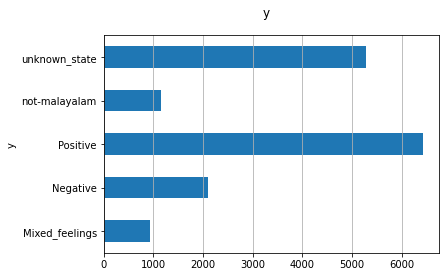

In [6]:
fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
mal_train.groupby("y").count().plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [7]:
# read in the list of stopwords in Kannada
with open('../stopwords-kn.txt') as file:
    lines = file.readlines()
    lines = [line.rstrip() for line in lines]

lst_stopwords = lines

In [8]:
# transliterate all data from english scrip to kannada script
from indictrans import Transliterator

# instantiate the trasnliteration
trn = Transliterator(source='eng', target='mal', build_lookup=True)

# save the text column as a list in order to improve performance.
orig_mal_train = (mal_train['text'].to_numpy()).tolist()

# create and empty list, iterate through the list of text and append the transliterated text to our list.
list_trans = []
for i in range(len(orig_mal_train)):
    list_trans.append(trn.transform(orig_mal_train[i]))
    
# append the transliterated texts as a column on original dataframe
mal_train['text_trans'] = list_trans

In [9]:
mal_train

,text,y,text_trans
0,Sunny chechi fans evide like adichu power kani...,unknown_state,സുനയ ചേചി ഫംസ ഏവീഡ് ലീകേ ആദിച്ചു പവര് കനികു🤣🤣
1,Angane july month ile ende aadyathe leave njan...,Positive,അംഗനേ ജൂലൈ മോംഥ ഇല് ഏംഡേ ആധ്യാത ലീവേ ന്ജന അംഗു...
2,ഏട്ടന്റെ പുതിയ പടത്തിനു വേണ്ടി കാത്തിരിക്കുന്ന...,unknown_state,ഏട്ടന്റെ പുതിയ പടത്തിനു വേണ്ടി കാത്തിരിക്കുന്ന...
3,ഇനി ലാലേട്ടന്റെ വേട്ട തുടങ്ങാൻ പോകുന്നു..........,Positive,ഇനി ലാലേട്ടന്റെ വേട്ട തുടങ്ങാൻ പോകുന്നു..........
4,Trailer powli oru raksha illa . Pakshea padam ...,Positive,ട്രേല്ര് പോവലീ ഓരു രക്ഷാ ഇല്ലാ . പക്ഷേം പദമ ഇര...
...,...,...,...
15883,Minimum 10 thavana kandavar maathram like adi,unknown_state,മിനിമുമ 10 താവാനാ കാന്ദാവര മാഥ്രാമ ലീകേ ആദി
15884,Please cinema kaannaaan kothi aakunnu onnu rel...,Positive,പ്ലീസ് സിനേമാം കാനാന കോതീ ആകുനനു ഓനനു റേലീസ് ച...
15885,USA ok.. India No... Sadhacharam,unknown_state,ഉസാ ഓക.. ഇന്ത്യാ നോ... സാധാചാരമ
15886,nama hero december 12 wait & see mamamaga mah...,Positive,നാമാം ഹീരോ ദേസംബര് 12 വാട & സീ മാമമാഗാ മഹാ മഗ...


In [10]:
# do the same for the dev data
# save the text column as a list in order to improve performance.
orig_mal_dev = (mal_dev['text'].to_numpy()).tolist()

# create and empty list, iterate through the list of text and append the transliterated text to our list.
list_trans_dev = []
for i in range(len(orig_mal_dev)):
    list_trans_dev.append(trn.transform(orig_mal_dev[i]))
    
# append the transliterated texts as a column on original dataframe
mal_dev['text_trans'] = list_trans_dev

In [11]:
mal_dev

,text,y,text_trans
0,Mammooka ninghal mass aa pwoli item,Positive,മമൂകാ നീന്ഘല മാസ ആ പ്വോലി ഇതേമ
1,Waiting for Malayalam movie For Tamil paiyan,not-malayalam,വൈറ്റിങ് ഫര മലയാളം മോവീഏ ഫര തമിഴ് പൈയാന
2,ദളപതി ഫാൻസിന്റെ വക ഒരു ഒന്നൊന്നര വിജയാശംസകൾ...,Positive,ദളപതി ഫാൻസിന്റെ വക ഒരു ഒന്നൊന്നര വിജയാശംസകൾ...
3,#Trailer pwolichuuuu ഓണത്തിന് വന്നങ്ങു തകർത്തേ...,Positive,#ട്രേല്ര് പ്വോലീചൂ ഓണത്തിന് വന്നങ്ങു തകർത്തേക്...
4,Mammoookkaaaa polichadukkiii katta waiting nv 21,Positive,മമൂക്കാ പോളിചാടുക്കീ കട്ടാ വൈറ്റിങ് നവ 21
...,...,...,...
1761,Aa ചിരി uff എന്റെ പൊന്നോ ഇക്ക vere ലെവൽ,Positive,ആ ചിരി ഉഫ്ഫ എന്റെ പൊന്നോ ഇക്ക വേരാ ലെവൽ
1762,Katta katta katta katta waiting....cant wait man,Positive,കട്ടാ കട്ടാ കട്ടാ കട്ടാ വൈറ്റിങ്....കാംത വാട മന
1763,Arjun reddy bgm poole thonniyathu enniku mathr...,unknown_state,അര്ജുന രേഡ്ഡ്യ ബ്ഗ്മ പൂലേ ഥോന്നീയതും എന്നീകു മ...
1764,Fahad ikka ithilum polikum en urappayi,Positive,ഫഹദ ഇക്കാ ഇതിലുമ പോളികുമ ഏന ഉരാപ്പായീ


In [12]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
:return
    cleaned text
'''
def utils_preprocess_text(text, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [13]:
#Now we can apply the preprocessing function to our data

mal_train["text_clean"] = mal_train["text_trans"].apply(lambda x: 
          utils_preprocess_text(x, lst_stopwords=lst_stopwords))

mal_dev["text_clean"] = mal_dev["text_trans"].apply(lambda x: 
          utils_preprocess_text(x, lst_stopwords=lst_stopwords))

In [14]:
mal_train

,text,y,text_trans,text_clean
0,Sunny chechi fans evide like adichu power kani...,unknown_state,സുനയ ചേചി ഫംസ ഏവീഡ് ലീകേ ആദിച്ചു പവര് കനികു🤣🤣,സനയ ചച ഫസ ഏവഡ ലക ആദചച പവര കനക
1,Angane july month ile ende aadyathe leave njan...,Positive,അംഗനേ ജൂലൈ മോംഥ ഇല് ഏംഡേ ആധ്യാത ലീവേ ന്ജന അംഗു...,അഗന ജല മഥ ഇല ഏഡ ആധയത ലവ നജന അഗ ഏദകവ ജല 5 ന
2,ഏട്ടന്റെ പുതിയ പടത്തിനു വേണ്ടി കാത്തിരിക്കുന്ന...,unknown_state,ഏട്ടന്റെ പുതിയ പടത്തിനു വേണ്ടി കാത്തിരിക്കുന്ന...,ഏടടനറ പതയ പടതതന വണട കതതരകകനനവർ ലക ബടടൺ അടചച പളകക
3,ഇനി ലാലേട്ടന്റെ വേട്ട തുടങ്ങാൻ പോകുന്നു..........,Positive,ഇനി ലാലേട്ടന്റെ വേട്ട തുടങ്ങാൻ പോകുന്നു..........,ഇന ലലടടനറ വടട തടങങൻ പകനന മൻ കല കളലകഷന റകകരദകല ...
4,Trailer powli oru raksha illa . Pakshea padam ...,Positive,ട്രേല്ര് പോവലീ ഓരു രക്ഷാ ഇല്ലാ . പക്ഷേം പദമ ഇര...,ടരലര പവല ഓര രകഷ ഇലല പകഷ പദമ ഇരഗതത വരഥ ഓവര ഡഗരഡ...
...,...,...,...,...
15883,Minimum 10 thavana kandavar maathram like adi,unknown_state,മിനിമുമ 10 താവാനാ കാന്ദാവര മാഥ്രാമ ലീകേ ആദി,മനമമ 10 തവന കനദവര മഥരമ ലക ആദ
15884,Please cinema kaannaaan kothi aakunnu onnu rel...,Positive,പ്ലീസ് സിനേമാം കാനാന കോതീ ആകുനനു ഓനനു റേലീസ് ച...,പലസ സനമ കനന കത ആകനന ഓനന റലസ ചയയ
15885,USA ok.. India No... Sadhacharam,unknown_state,ഉസാ ഓക.. ഇന്ത്യാ നോ... സാധാചാരമ,ഉസ ഓക ഇനതയ ന സധചരമ
15886,nama hero december 12 wait & see mamamaga mah...,Positive,നാമാം ഹീരോ ദേസംബര് 12 വാട & സീ മാമമാഗാ മഹാ മഗ...,നമ ഹര ദസബര 12 വട സ മമമഗ മഹ മഗമ കകലരക കഡല ദ ഫസ ...


In [15]:
# Now we can define our training data and our dev data as well as targets
train = mal_train
test = mal_dev

y_train = mal_train['y'].values
y_test = mal_dev['y'].values


In [16]:
# for ensemble: 
results = pd.DataFrame(mal_dev['y'])

# Gettint text embeddings from the bert model

In [17]:
# I'll be using the embeddings from the multilinngual bert model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-uncased')
model = AutoModel.from_pretrained('bert-base-multilingual-uncased').to(device)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
# We will start by gathering the embeddings for the validation set
cls_val_list = []
batch_size = 1000

for batch_number, batch_test in test.groupby(np.arange(len(test)) // batch_size):
    # tokanizing the text
    tokenized_val = tokenizer(batch_test["text_clean"].values.tolist() , padding = 'max_length', truncation = True,  return_tensors="pt", max_length=256)

    # move on device (GPU)
    tokenized_val = {k:torch.tensor(v).to(device) for k,v in tokenized_val.items()}

    # get the cls hidden state
    with torch.no_grad():
        hidden_val = model(**tokenized_val)
            
    #get only the [CLS] hidden states
    cls_val = hidden_val.last_hidden_state[:,0,:]
    cls_val = cls_val.to("cpu")
    cls_val_list.append(cls_val)
    del cls_val
    del hidden_val
    del tokenized_val
    
    torch.cuda.empty_cache()

cls_val_list_final = []
for i in range(len(cls_val_list)):
    for j in range(len(cls_val_list[i])):
        cls_val_list_final.append(cls_val_list[i][j])


/home/ubuntu/pyenv/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


In [19]:
# Get embeddigns for the trainins set
cls_train_list = []
batch_size = 1000

for batch_number, batch_train in train.groupby(np.arange(len(train)) // batch_size):
    # tokanizing the text
    tokenized_train = tokenizer(batch_train["text_clean"].values.tolist() , padding = 'max_length', truncation = True,  return_tensors="pt", max_length=256)

    # move on device (GPU)
    tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_train.items()}

    # get the cls hidden state
    with torch.no_grad():
        hidden_train = model(**tokenized_train)
            
    #get only the [CLS] hidden states
    cls_train = hidden_train.last_hidden_state[:,0,:]
    cls_train = cls_train.to("cpu")
    cls_train_list.append(cls_train)
    del cls_train
    del hidden_train
    del tokenized_train
    
    torch.cuda.empty_cache()

cls_train_list_final = []
for i in range(len(cls_train_list)):
    for j in range(len(cls_train_list[i])):
        cls_train_list_final.append(cls_train_list[i][j])

/home/ubuntu/pyenv/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


In [21]:
# Move the poutput embeddigns for the trainign and validation sets into a dataframe
X_train = torch.stack(cls_train_list_final)
X_train = pd.DataFrame(X_train)

X_test = torch.stack(cls_val_list_final)
X_test = pd.DataFrame(X_test)

y_train = mal_train['y'].values
y_test = mal_dev['y'].values

# Training a cat boost classifier

In [22]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(iterations=150, learning_rate=.5)

In [23]:
## train classifier
cat.fit(X_train, y_train)
predicted = cat.predict(X_test)
results['cat_boost_cleaned_bert'] = predicted
predicted_prob = cat.predict_proba(X_test)

0:	learn: 1.4108817	total: 639ms	remaining: 1m 35s
1:	learn: 1.3339944	total: 1.1s	remaining: 1m 21s
2:	learn: 1.2931776	total: 1.5s	remaining: 1m 13s
3:	learn: 1.2694853	total: 1.9s	remaining: 1m 9s
4:	learn: 1.2477040	total: 2.33s	remaining: 1m 7s
5:	learn: 1.2312164	total: 2.77s	remaining: 1m 6s
6:	learn: 1.2167823	total: 3.22s	remaining: 1m 5s
7:	learn: 1.2026904	total: 3.62s	remaining: 1m 4s
8:	learn: 1.1909299	total: 4.06s	remaining: 1m 3s
9:	learn: 1.1769008	total: 4.48s	remaining: 1m 2s
10:	learn: 1.1663689	total: 4.89s	remaining: 1m 1s
11:	learn: 1.1601735	total: 5.3s	remaining: 1m
12:	learn: 1.1521314	total: 5.69s	remaining: 59.9s
13:	learn: 1.1457714	total: 6.1s	remaining: 59.3s
14:	learn: 1.1363688	total: 6.55s	remaining: 59s
15:	learn: 1.1298844	total: 6.99s	remaining: 58.5s
16:	learn: 1.1194683	total: 7.4s	remaining: 57.9s
17:	learn: 1.1113522	total: 7.81s	remaining: 57.3s
18:	learn: 1.1014635	total: 8.26s	remaining: 56.9s
19:	learn: 1.0935825	total: 8.69s	remaining: 56.5

Accuracy: 0.54
Auc: 0.76
Detail:
                precision    recall  f1-score   support

Mixed_feelings       0.32      0.08      0.13       102
      Negative       0.34      0.18      0.24       237
      Positive       0.55      0.71      0.62       706
 not-malayalam       0.62      0.52      0.56       141
 unknown_state       0.54      0.55      0.55       580

      accuracy                           0.54      1766
     macro avg       0.47      0.41      0.42      1766
  weighted avg       0.51      0.54      0.51      1766



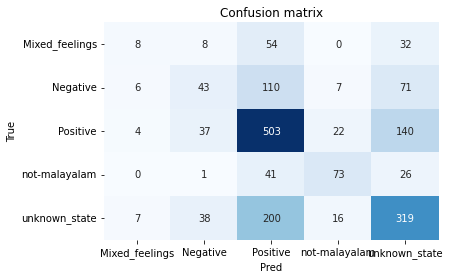

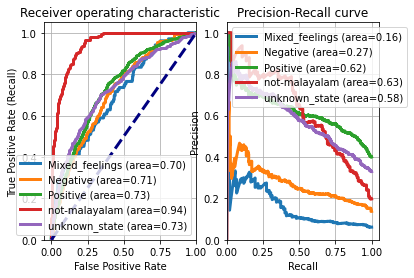

In [24]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# Training a Random Forest Classifier

In [25]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(max_depth=150, n_estimators=15, max_features=768)

In [26]:
## train classifier
forest.fit(X_train, y_train)
## test
predicted = forest.predict(X_test)
results['forest_cleaned_bert'] = predicted
predicted_prob = forest.predict_proba(X_test)

Accuracy: 0.48
Auc: 0.69
Detail:
                precision    recall  f1-score   support

Mixed_feelings       0.47      0.07      0.12       102
      Negative       0.30      0.14      0.19       237
      Positive       0.49      0.71      0.58       706
 not-malayalam       0.63      0.31      0.42       141
 unknown_state       0.49      0.46      0.47       580

      accuracy                           0.48      1766
     macro avg       0.47      0.34      0.36      1766
  weighted avg       0.47      0.48      0.45      1766



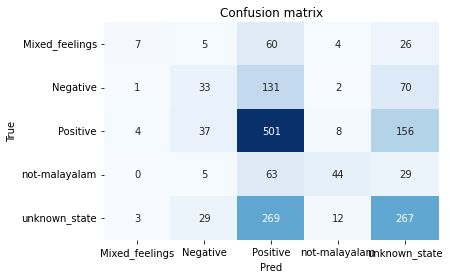

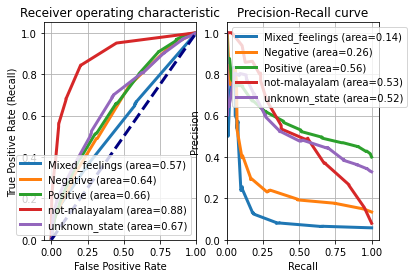

In [27]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# fitting a logistic regression classifier

In [28]:
from sklearn.linear_model import LogisticRegression
log =LogisticRegression(random_state=0, max_iter= 300)

In [29]:
## pipeline

## train classifier
log.fit(X_train, y_train)
## test
predicted = log.predict(X_test)
results['log_cleaned_bert'] = predicted
predicted_prob = log.predict_proba(X_test)

/home/ubuntu/pyenv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.55
Auc: 0.78
Detail:
                precision    recall  f1-score   support

Mixed_feelings       0.20      0.01      0.02       102
      Negative       0.38      0.11      0.17       237
      Positive       0.54      0.76      0.63       706
 not-malayalam       0.62      0.43      0.51       141
 unknown_state       0.56      0.59      0.58       580

      accuracy                           0.55      1766
     macro avg       0.46      0.38      0.38      1766
  weighted avg       0.52      0.55      0.51      1766



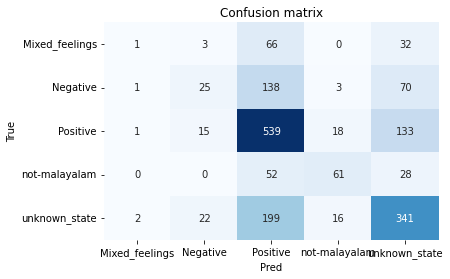

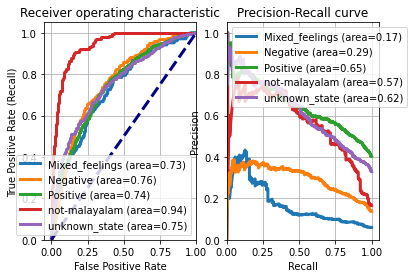

In [30]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# training a k-neighboot classifier

In [31]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3, weights='distance')

In [32]:

## train classifier
neigh.fit(X_train, y_train)
## test
predicted = neigh.predict(X_test)
results['neigh_cleaned_bert'] = predicted
predicted_prob = neigh.predict_proba(X_test)

Accuracy: 0.5
Auc: 0.69
Detail:
                precision    recall  f1-score   support

Mixed_feelings       0.20      0.19      0.19       102
      Negative       0.33      0.25      0.29       237
      Positive       0.54      0.62      0.58       706
 not-malayalam       0.54      0.48      0.51       141
 unknown_state       0.54      0.52      0.53       580

      accuracy                           0.50      1766
     macro avg       0.43      0.41      0.42      1766
  weighted avg       0.49      0.50      0.49      1766



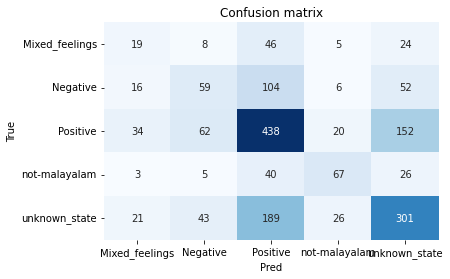

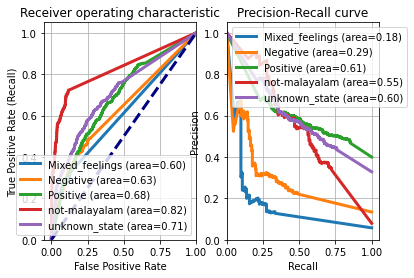

In [33]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# Ensemble 

In [34]:
results.replace(['Negative', 'Positive','not-malayalam', 'Mixed_feelings','unknown_state' ], [0,1,2,3,4], inplace=True)
results['cleaned_majority_label_bert'] = results[results.columns[1:]].mode(axis=1)[0].astype(int)
results.replace([0,1,2,3,4], ['Negative', 'Positive','not-malayalam', 'Mixed_feelings','unknown_state' ], inplace=True)
results.to_csv('mal_results_cleaned_bert.tsv', sep="\t", index = False)

                precision    recall  f1-score   support

Mixed_feelings       0.60      0.09      0.15       102
      Negative       0.42      0.19      0.26       237
      Positive       0.53      0.83      0.65       706
 not-malayalam       0.72      0.44      0.55       141
 unknown_state       0.64      0.51      0.56       580

      accuracy                           0.56      1766
     macro avg       0.58      0.41      0.43      1766
  weighted avg       0.57      0.56      0.53      1766



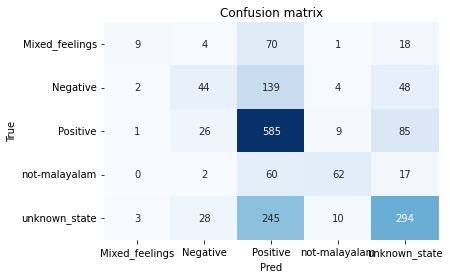

In [35]:
## Plot confusion matrix
print(metrics.classification_report(results['y'], results['cleaned_majority_label_bert']))
cm = metrics.confusion_matrix(results['y'], results['cleaned_majority_label_bert'])
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()